In [1088]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix    
import numpy as np


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### **1. Data Loading and Merging**

In [1089]:
data2009 = pd.read_csv('../data/raw/dataset_2009.csv')
data2011 = pd.read_csv('../data/raw/dataset_2011.csv')
data2013 = pd.read_csv('../data/raw/dataset_2013.csv')
data2015 = pd.read_csv('../data/raw/dataset_2015.csv')
data2017 = pd.read_csv('../data/raw/dataset_2017.csv')

In [1090]:
# Cheking unique columns
first = data2015.columns
second = data2013.columns

only_in_2015_2016 = set(first) - set(second)

print(" Unique coloumns 2015-2016:", only_in_2015_2016)


 Unique coloumns 2015-2016: {'LBXHSCRP', 'LBDFERSI', 'SLQ120'}


### **2. Handling Missing Glucose Data**

In [1091]:
df = pd.concat([data2009,data2011, data2013, data2015, data2017], axis=0, ignore_index=True)
print("Intiale data: ", df.shape)


#df = df.dropna(subset=['LBDGLUSI', 'LBXGH', 'LBXIN'])
print("After dropna : ",df.shape)
df[['LBDGLUSI', 'LBXGH', 'LBXIN']].isna().sum()


Intiale data:  (55976, 80)
After dropna :  (55976, 80)


LBDGLUSI    38675
LBXGH       20212
LBXIN       39125
dtype: int64

In [1092]:
categorical_features = [
        'SDDSRVYR','RIAGENDR', 'RIDRETH3', 'DMDBORN4', 'DMDEDUC2','RIDEXPRG', 'DMDMARTZ',
        'ALQ111', 'ALQ121', 'ALQ142','ALQ151','BPQ020','BPQ040A','BPQ050A','BPQ080','BPQ090D',
        'DIQ160','DIQ010','DBQ197','DBQ700','HIQ011','INDFMMPC','MCQ080','MCQ160B','MCQ160C','MCQ160M','MCQ300C',
        'DPQ020','DPQ030','DPQ040','DPQ060','DPQ070','PAQ605','PAQ620','PAQ635','PAQ650','PAQ665','SLD012','SLQ120',
        'SMQ020','SMQ040'
    ]
    
numerical_features = [col for col in df.columns if col not in categorical_features]



### **3.  Data Cleaning** 

In [1093]:
# This section focuses on data cleaning by filtering out irrelevant or inconsistent categorical values

for col in categorical_features:
    print(f"Feature: {col}")
    print(df[col].value_counts(dropna=False))  
    print("-" * 50)



Feature: SDDSRVYR
2017-2020    15560
2009-2010    10529
2013-2013    10168
2015-2016     9971
2011-2012     9748
Name: SDDSRVYR, dtype: int64
--------------------------------------------------
Feature: RIAGENDR
2.0    28291
1.0    27685
Name: RIAGENDR, dtype: int64
--------------------------------------------------
Feature: RIDRETH3
3.0    19396
4.0    13127
1.0     9378
2.0     6018
6.0     5035
7.0     2380
5.0      642
Name: RIDRETH3, dtype: int64
--------------------------------------------------
Feature: DMDBORN4
1.0     44710
2.0     11241
77.0       18
99.0        7
Name: DMDBORN4, dtype: int64
--------------------------------------------------
Feature: DMDEDUC2
NaN    23497
4.0     9829
5.0     7776
3.0     7357
2.0     4289
1.0     3182
9.0       36
7.0       10
Name: DMDEDUC2, dtype: int64
--------------------------------------------------
Feature: RIDEXPRG
NaN    48896
2.0     6207
3.0      526
1.0      347
Name: RIDEXPRG, dtype: int64
---------------------------------------

In [1094]:
def process_categorical_feature(df, column, replace_values=None, mapping=None):
    """Replaces specific categories and applies mapping."""
    if column not in df.columns:
        print(f"Column {column} not found in DataFrame!")
        return df

    # Replace values (merging categories)
    if replace_values:
        df[column] = df[column].replace(replace_values, 33)  # Merge into category 33

    # Apply mapping (renaming categories)
    if mapping:
        df[column] = df[column].map(mapping)

    return df

# List of columns where 7 and 9 should be merged
merge_7_9 = ["DMDEDUC2","ALQ111","ALQ151","BPQ020","BPQ040A","BPQ050A","BPQ080","BPQ090D","DIQ160","DIQ010",
             "DBQ197","DBQ700","HIQ011","INDFMMPC","MCQ080","MCQ160B","MCQ160C","MCQ160M","MCQ300C",
             "DPQ020","DPQ030","DPQ040","DPQ060","DPQ070","PAQ605","PAQ620","PAQ635","PAQ650","PAQ665","SLQ120",
             "SMQ020","SMQ040"]

# Define processing rules
processing_rules = {
    "DMDBORN4": {"replace_values": [77, 99]},  # Merge 77 and 99 into 33
    "DMDMARTZ": {"replace_values": [77, 99]},  # Merge 77 and 99 into 33
    "ALQ121": {"replace_values": [77, 99],        
               "mapping": {
                   0: 0,  # Never in the last year -> 0
                   1: 1,  # Every day -> 1 (Frequent)
                   2: 1,  # Nearly every day -> 1 (Frequent)
                   3: 2,  # 3 to 4 times a week -> 2 (Regular)
                   4: 2,  # 2 times a week -> 2 (Regular)
                   5: 3,  # Once a week -> 3 (Occasional)
                   6: 3,  # 2 to 3 times a month -> 3 (Occasional)
                   7: 4,  # Once a month -> 4 (Rare)
                   8: 4,  # 7 to 11 times a year -> 4 (Rare)
                   9: 5,  # 3 to 6 times a year -> 5 (Very Rare)
                   10: 5  # 1 to 2 times a year -> 5 (Very Rare)
               }
    },
    "ALQ142": {"replace_values": [77, 99],
               "mapping": {
                   0: 0,  # Never in the last year -> 0
                   1: 1,  # Every day -> 1 (Frequent)
                   2: 1,  # Nearly every day -> 1 (Frequent)
                   3: 2,  # 3 to 4 times a week -> 2 (Regular)
                   4: 2,  # 2 times a week -> 2 (Regular)
                   5: 3,  # Once a week -> 3 (Occasional)
                   6: 3,  # 2 to 3 times a month -> 3 (Occasional)
                   7: 4,  # Once a month -> 4 (Rare)
                   8: 4,  # 7 to 11 times a year -> 4 (Rare)
                   9: 5,  # 3 to 6 times a year -> 5 (Very Rare)
                   10: 5  # 1 to 2 times a year -> 5 (Very Rare)
               }
    },
    **{col: {"replace_values": [7, 9]} for col in merge_7_9},  # Merge 7 and 9 into 33 for all columns in the list

}

# Apply processing rules
for column, rules in processing_rules.items():
    df = process_categorical_feature(df, column, replace_values=rules.get("replace_values"), mapping=rules.get("mapping"))

def categorize_sld012(value):
    if pd.isna(value):
        return None
    elif value < 3:
        return 1  # "<3 hours"
    elif value < 6:
        return 2  # "<6 hours"
    elif value < 8:
        return 3  # "<8 hours"
    elif value < 11:
        return 4  # "<11 hours"
    else:
        return 5  # ">=11 hours"

df["SLD012"] = df["SLD012"].apply(categorize_sld012)

In [1095]:
# This section focuses on data cleaning by filtering out irrelevant or inconsistent categorical values

for col in categorical_features:
    print(f"Feature: {col}")
    print(df[col].value_counts(dropna=False))  
    print("-" * 50)


Feature: SDDSRVYR
2017-2020    15560
2009-2010    10529
2013-2013    10168
2015-2016     9971
2011-2012     9748
Name: SDDSRVYR, dtype: int64
--------------------------------------------------
Feature: RIAGENDR
2.0    28291
1.0    27685
Name: RIAGENDR, dtype: int64
--------------------------------------------------
Feature: RIDRETH3
3.0    19396
4.0    13127
1.0     9378
2.0     6018
6.0     5035
7.0     2380
5.0      642
Name: RIDRETH3, dtype: int64
--------------------------------------------------
Feature: DMDBORN4
1.0     44710
2.0     11241
33.0       25
Name: DMDBORN4, dtype: int64
--------------------------------------------------
Feature: DMDEDUC2
NaN     23497
4.0      9829
5.0      7776
3.0      7357
2.0      4289
1.0      3182
33.0       46
Name: DMDEDUC2, dtype: int64
--------------------------------------------------
Feature: RIDEXPRG
NaN    48896
2.0     6207
3.0      526
1.0      347
Name: RIDEXPRG, dtype: int64
--------------------------------------------------
Feature:

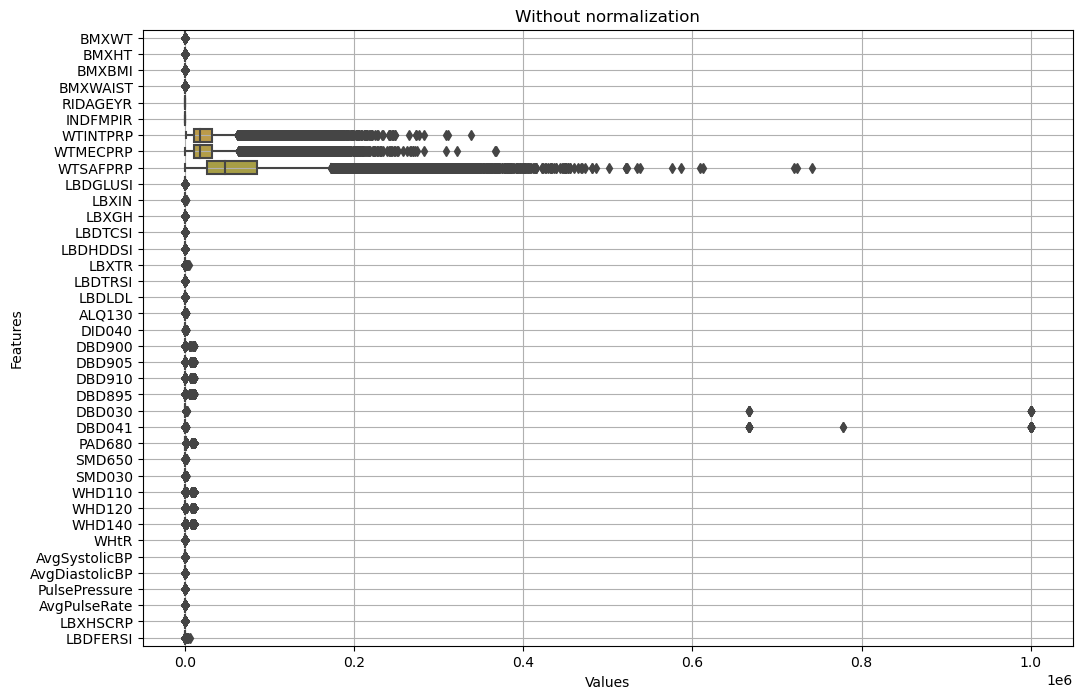

In [1096]:
fig, ax = plt.subplots(figsize=(12, 8)) 

sns.boxplot(data=df[numerical_features], orient='h', ax=ax)

ax.set_title('Without normalization')
ax.set_xlabel('Values')
ax.set_ylabel('Features')
#ax.set_xlim(0, 200)
ax.grid(True)

plt.show()


In [1097]:
df.shape

(55976, 80)

### **3. Feature Engineering.** 
#### **3.1 Creation of Diabetes Status and HOMA-IR**

In [1098]:
# Creating HOMA-IR 
# Formula: HOMA-IR = (Fasting Glucose * Insulin) / 22.5

df['HOMA_IR'] = (df['LBDGLUSI'] * df['LBXIN']) / 22.5

#Diabetes_Status

def determine_diabetes_status(row):
    # if NaN → Возвращаем NaN
    if pd.isna(row['LBDGLUSI']) or pd.isna(row['LBXGH']):
        return np.nan  
    if row['LBDGLUSI'] >= 7.0 or row['LBXGH'] >= 6.5:
        return 2  # Diabetes
    elif 5.6 <= row['LBDGLUSI'] < 7.0 or 5.7 <= row['LBXGH'] < 6.5:
        return 1  # Prediabetes
    else:
        return 0  # Normal

# creation target 1 
df['Diabetes_Status'] = df.apply(determine_diabetes_status, axis=1)

# Assign Insulin_Resistance based on HOMA-IR > 2.9
#df['Insulin_Resistance'] = (df['HOMA_IR'] > 2.9).astype(int)
df['Insulin_Resistance'] = np.where(df['HOMA_IR'].isna(), np.nan, (df['HOMA_IR'] > 2.9).astype(int))

print(df['Diabetes_Status'].value_counts())
print(df['Insulin_Resistance'].value_counts())


0.0    8706
1.0    6289
2.0    2272
Name: Diabetes_Status, dtype: int64
0.0    9688
1.0    7147
Name: Insulin_Resistance, dtype: int64


#### **3.2 Creation of Metabolic Syndrome (MetS) Indicator**

In [1099]:
def detect_metabolic_syndrome(df):
    """Detects Metabolic Syndrome (MetS) ensuring at least 3 valid criteria."""

    # 1. Waist circumference (cm) - Gender-specific threshold
    df["MetS_WC"] = np.where(
        df["BMXWAIST"].notna() & df["RIAGENDR"].notna(),  # Ensure values exist
        np.where(
            ((df["BMXWAIST"] >= 94) & (df["RIAGENDR"] == 1)) |  # Men: ≥102 cm
            ((df["BMXWAIST"] >= 80) & (df["RIAGENDR"] == 2)),   # Women: ≥88 cm
            1, 0  # 1 if MetS condition met, otherwise 0
        ),
        np.nan  # Missing data remains NaN
    )

    # 2. Triglycerides (mmol/L)
    df["MetS_TG"] = np.where(df["LBDTRSI"].notna(), np.where(df["LBDTRSI"] >= 1.7, 1, 0), np.nan)

    # 3. HDL cholesterol (mmol/L) - Gender-specific threshold
    df["MetS_HDL"] = np.where(
        df["LBDHDDSI"].notna() & df["RIAGENDR"].notna(),
        np.where(
            ((df["LBDHDDSI"] < 1.03) & (df["RIAGENDR"] == 1)) |  # Men: <1.03 mmol/L
            ((df["LBDHDDSI"] < 1.29) & (df["RIAGENDR"] == 2)) |   # Women: <1.29 mmol/L
            (df["BPQ090D"] == 1),  # If taking medication for cholesterol, count as MetS
            1, 0
        ),
        np.nan
    )

    # 4. Blood pressure (mmHg)
    df["MetS_BP"] = np.where(
        df["AvgSystolicBP"].notna() & df["AvgDiastolicBP"].notna(),  # Ensure BP values exist
        np.where(
            (df["AvgSystolicBP"] >= 130) | (df["AvgDiastolicBP"] >= 85) |  # Hypertension criteria
            (df[["BPQ040A", "BPQ050A"]].eq(1).any(axis=1)),  # Taking hypertension meds
            1, 0 
        ),
        np.nan  # Missing values remain NaN
    )

    # 5. Fasting glucose (mmol/L)
    df["MetS_FPG"] = np.where(df["LBDGLUSI"].notna(), np.where(df["LBDGLUSI"] >= 5.6, 1, 0), np.nan)

    # List of criteria columns
    criteria_cols = ["MetS_WC", "MetS_TG", "MetS_HDL", "MetS_BP", "MetS_FPG"]

    # Count valid (non-null) criteria
    df["Valid_MetS_Criteria"] = df[criteria_cols].notna().sum(axis=1)

    # Sum of MetS criteria (ensuring at least 3 valid criteria)
    df["MetS_Criteria"] = df[criteria_cols].sum(axis=1, min_count=3)

    df["MetS_3"] = np.where(
    df["MetS_Criteria"].notna(),  # Ensure MetS_Criteria is not NaN
    np.where(
        df["MetS_Criteria"] >= 3,  # If at least 3 criteria are met
        1,  # Metabolic syndrome present
        0   # Metabolic syndrome absent
    ),
    np.nan  # Missing data remains NaN
    )

    df["MetS_4"] = np.where(
    df["MetS_Criteria"].notna(),  # Ensure MetS_Criteria is not NaN
    np.where(
        df["MetS_Criteria"] >= 4,  # If at least 4 criteria are met
        1,  # Metabolic syndrome present
        0   # Metabolic syndrome absent
    ),
    np.nan  # Missing data remains NaN
    )

    return df

df = detect_metabolic_syndrome(df)

In [1100]:
df.shape

(55976, 92)

In [1101]:
# Список признаков, используемых в критериях метаболического синдрома
criteria_columns = ["SEQN","BMXWAIST", "RIAGENDR", "LBDTRSI", "LBDHDDSI", "AvgSystolicBP", "AvgDiastolicBP", "LBDGLUSI",
                     'MetS_WC', 'MetS_TG', 'MetS_HDL', 'MetS_BP',
       'MetS_FPG', 'Valid_MetS_Criteria', 'MetS_Criteria', 'MetS_3', 'MetS_4',"Diabetes_Status","Insulin_Resistance"]

# Вывод первых строк датафрейма только с нужными колонками
df_criteria = df[criteria_columns]
df_criteria.head()

,SEQN,BMXWAIST,RIAGENDR,LBDTRSI,LBDHDDSI,AvgSystolicBP,AvgDiastolicBP,LBDGLUSI,MetS_WC,MetS_TG,MetS_HDL,MetS_BP,MetS_FPG,Valid_MetS_Criteria,MetS_Criteria,MetS_3,MetS_4,Diabetes_Status,Insulin_Resistance
0,51624.0_2009-2010,100.4,1.0,NaN,1.29,113.333333,86.000000,NaN,1.0,NaN,0.0,1.0,NaN,3,2.0,0.0,0.0,NaN,NaN
1,51625.0_2009-2010,49.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
2,51626.0_2009-2010,74.7,1.0,NaN,1.55,110.000000,60.000000,NaN,0.0,NaN,0.0,0.0,NaN,3,0.0,0.0,0.0,NaN,NaN
3,51627.0_2009-2010,63.0,1.0,NaN,1.89,92.666667,39.333333,NaN,0.0,NaN,0.0,0.0,NaN,3,0.0,0.0,0.0,NaN,NaN
4,51628.0_2009-2010,118.2,2.0,NaN,1.16,151.333333,68.666667,NaN,1.0,NaN,1.0,1.0,NaN,3,3.0,1.0,0.0,NaN,NaN


## DATA
"""
# Dataset Variables Description

## 1. Identifier
1. **SEQN**: Unique respondent identifier.

## 2. Body Measures (P_BMX)
NUM  2. **BMXWT**: Weight (kg).
NUM  3. **BMXHT**: Height (cm).
NUM  4. **BMXBMI**: Body Mass Index (kg/m²).
NUM  5. **BMXWAIST**: Waist circumference (cm).
NUM  6. **WHtR**: Waist-to-height ratio (BMXWAIST / BMXHT).

## 3. Blood Pressure (P_BPXO)
NUM  7. **AvgSystolicBP**: Average systolic blood pressure (mmHg).
NUM  8. **AvgDiastolicBP**: Average diastolic blood pressure (mmHg).
NUM  9. **PulsePressure**: Pulse pressure (mmHg).
NUM  10. **AvgPulseRate**: Average pulse rate (beats per minute).

## 4. Demographics Data (P_DEMO)
obj  11. **SDDSRVYR**: Survey cycle (year).
obj  12. **RIAGENDR**: Gender (1 = Male, 2 = Female).
NUM  13. **RIDAGEYR**: Age (years).
obj  14. **RIDRETH3**: Race/Ethnicity.
obj  15. **DMDBORN4**: Country of birth.
obj  16. **DMDEDUC2**: Education level.
obj  17. **RIDEXPRG**: Pregnancy status.
NUM  18. **INDFMPIR**: Income-to-poverty ratio.
obj  19. **DMDMARTZ**: Marital status.

## 5. Lab Tests (P_LAB)
NUM  20. **WTINTPRP**: Weighting factor for interview.
NUM  21. **WTMECPRP**: Weighting factor for physical examination.
NUM  22. **WTSAFPRP**: Weighting factor for fasting measures.
NUM  23. **LBDGLUSI**: Fasting glucose (mmol/L).
NUM  24. **LBXIN**: Insulin (µU/mL).
NUM  25. **LBXGH**: Glycated hemoglobin (HbA1c, %).
NUM  26. **LBDTCSI**: Total cholesterol (mmol/L).
NUM  27. **LBDHDDSI**: HDL cholesterol (mmol/L).
NUM  28. **LBXTR**: Triglycerides (mg/dL).
NUM  29. **LBDTRSI**: Triglycerides (mmol/L).
NUM  30. **LBDLDL**: LDL cholesterol (mmol/L).
NUM  31. **LBXHSCRP**: High-sensitivity C-reactive protein (mg/L).
NUM  32. **LBDFERSI**: Ferritin (µg/L).
NUM  33. **HOMA_IR**: Homeostatic Model Assessment for Insulin Resistance.

## 6. Alcohol Use (P_ALQ)
obj  34. **ALQ111**: Ever had a drink of any kind of alcohol? (*2017-2020*)/Had at least 12 alcohol drinks/lifetime?(*before 2015*)
obj  35. **ALQ121**: Alcohol consumption frequency in the past year.
NUM  36. **ALQ130**: Average number of drinks per day.
obj  37. **ALQ142**: Number of drinking days in the past 12 months.
obj  38. **ALQ151**: Binge drinking episodes. 4/5 days 

## 7. Blood Pressure & Cholesterol (P_BPQ)
obj  39. **BPQ020**: Diagnosed with hypertension.
obj  40. **BPQ040A**: Taking hypertension medication.
obj  41. **BPQ050A**: Taking medication for high blood pressure.
obj  42. **BPQ080**: Diagnosed with high cholesterol.
obj  43. **BPQ090D**: Taking medication for high cholesterol.

## 8. Diabetes (P_DIQ)
obj  44. **DIQ160**: Ever told you have prediabetes.
obj  45. **DIQ010**: Doctor told you have diabetes.
NUM  46. **DID040**: Age when first diagnosed with diabetes.

## 9. Diet Behavior & Nutrition (P_DBQ)
NUM  47. **DBD900**: Number of fast food meals in the past 30 days.
NUM  48. **DBD905**: Number of ready-to-eat meals in the past 30 days.
NUM  49. **DBD910**: Number of frozen meals in the past 30 days.
obj  50. **DBQ197**: Milk product consumption in the past 30 days.
NUM  51. **DBD895**: Number of meals eaten away from home.
NUM  52. **DBD030**: Age stopped breastfeeding (days).
NUM  53. **DBD041**: Age first fed formula (days).
obj  54. **DBQ700**: How healthy is the diet

## 10. Health Insurance (P_HIQ) & Income (P_INQ)
obj  55. **HIQ011**: Has health insurance (Yes/No).
obj  56. **INDFMMPC**: Family monthly income-to-poverty ratio.

## 11. Medical Conditions (P_MCQ)
obj  57. **MCQ080**: Doctor advised about being overweight.
obj  58. **MCQ160B**: History of heart failure.
obj  59. **MCQ160C**: History of ischemic heart disease.
obj  60. **MCQ160M**: History of thyroid problems.
obj  61. **MCQ300C**: Family history of diabetes.

## 12. Mental Health - Depression Screener (P_DPQ)
obj  62. **DPQ020**: Feeling down, depressed, or hopeless.
obj  63. **DPQ030**: Sleep problems.
obj  64. **DPQ040**: Feeling tired or lacking energy.
obj  65. **DPQ060**: Low self-esteem.
obj  66. **DPQ070**: Difficulty concentrating.

## 13. Physical Activity (P_PAQ)
obj  67. **PAQ605**: Active job.
obj  68. **PAQ620**: Moderate work activity.
obj  69. **PAQ635**: Walking or cycling.
obj  70. **PAQ650**: Active leisure time.
obj  71. **PAQ665**: Moderate exercise frequency.
NUM  72. **PAD680**: Minutes of sedentary activity per day.

## 14. Sleep Disorders (P_SLQ)
obj  73. **SLD012**: Average sleep duration on weekdays. !!!!!!
obj  74. **SLQ120**: Frequency of excessive daytime sleepiness.

## 15. Smoking - Cigarette Use (P_SMQ)
obj  75. **SMQ020**: Ever smoked 100 or more cigarettes.
NUM  76. **SMD650**: Average cigarettes per day in the past 30 days.
NUM  77. **SMD030**: Age started smoking regularly.
obj  78. **SMQ040**: Do you currently smoke cigarettes?

## 16. Weight History (P_WHQ)
NUM  79. **WHD110**: Weight 10 years ago (lbs).
NUM  80. **WHD120**: Weight at age 25 (lbs).
NUM  81. **WHD140**: Maximum lifetime weight (lbs).

## 17. Target Variables
obj  82. **Diabetes_Status**: Diabetes diagnosis (Yes/No).
obj  83. **Insulin_Resistance**: Diagnosed insulin resistance (Yes/No).
"""

In [923]:
desired_order = [
    "SEQN",  # Identifier
    # Body Measures
    "BMXWT", "BMXHT", "BMXBMI", "BMXWAIST", "WHtR",
    # Blood Pressure
    "AvgSystolicBP", "AvgDiastolicBP", "PulsePressure", "AvgPulseRate",
    # Demographics
    "SDDSRVYR", "RIAGENDR", "RIDAGEYR", "RIDRETH3", "DMDBORN4", "DMDEDUC2", "RIDEXPRG",
    "INDFMPIR", "DMDMARTZ",
    # Lab Tests
    "WTINTPRP", "WTMECPRP", "WTSAFPRP", "LBDGLUSI", "LBXIN", "LBXGH", "LBDTCSI",
    "LBDHDDSI", "LBXTR", "LBDTRSI", "LBDLDL", "LBXHSCRP", "LBDFERSI", "HOMA_IR",
    # Alcohol Use
    "ALQ111", "ALQ121", "ALQ130", "ALQ142", "ALQ151",
    # Blood Pressure & Cholesterol
    "BPQ020", "BPQ040A", "BPQ050A", "BPQ080", "BPQ090D",
    # Diabetes
    "DIQ160", "DIQ010", "DID040",
    # Diet Behavior & Nutrition
    "DBD900", "DBD905", "DBD910", "DBQ197", "DBD895", "DBD030", "DBD041", "DBQ700",
    # Health Insurance & Income
    "HIQ011", "INDFMMPC",
    # Medical Conditions
    "MCQ080", "MCQ160B", "MCQ160C", "MCQ160M", "MCQ300C",
    # Mental Health
    "DPQ020", "DPQ030", "DPQ040", "DPQ060", "DPQ070",
    # Physical Activity
    "PAQ605", "PAQ620", "PAQ635", "PAQ650", "PAQ665", "PAD680",
    # Smoking
    "SMQ020", "SMD650", "SMD030", "SMQ040",
    # Weight History
    "WHD110", "WHD120", "WHD140",
    # Sleep Disorders
    "SLD012", "SLQ120",
    #for target 
    'MetS_WC', 'MetS_TG', 'MetS_HDL', 'MetS_BP', 'MetS_FPG', 'Valid_MetS_Criteria', 'MetS_Criteria',
    # Target Variables
    "Diabetes_Status", "Insulin_Resistance","MetS_3","MetS_4"
]

existing_columns = [col for col in desired_order if col in df.columns]

df = df[existing_columns]

print("Dataset shape after adding 'Diabetes_Status', 'Insulin_Resistance', 'HOMA_IR'")
print(df.shape)


#df.to_csv("df_2009-2020Total.csv", index=False, encoding="utf-8")

Dataset shape after adding 'Diabetes_Status', 'Insulin_Resistance', 'HOMA_IR'
(55976, 92)


,BMXWAIST,RIAGENDR,LBDTRSI,LBDHDDSI,AvgSystolicBP,AvgDiastolicBP,LBDGLUSI,MetS_WC,MetS_TG,MetS_HDL,MetS_BP,MetS_FPG,Valid_MetS_Criteria,MetS_Criteria,MetS_3,MetS_4
0,100.4,1.0,NaN,1.29,113.333333,86.000000,NaN,0.0,NaN,0.0,1.0,NaN,3,1.0,0.0,0.0
1,49.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
2,74.7,1.0,NaN,1.55,110.000000,60.000000,NaN,0.0,NaN,0.0,0.0,NaN,3,0.0,0.0,0.0
3,63.0,1.0,NaN,1.89,92.666667,39.333333,NaN,0.0,NaN,0.0,0.0,NaN,3,0.0,0.0,0.0
4,118.2,2.0,NaN,1.16,151.333333,68.666667,NaN,1.0,NaN,1.0,1.0,NaN,3,3.0,1.0,0.0
5,103.7,1.0,NaN,1.16,103.333333,49.333333,NaN,1.0,NaN,0.0,0.0,NaN,3,1.0,0.0,0.0
6,107.8,2.0,NaN,1.16,114.000000,77.333333,NaN,1.0,NaN,1.0,0.0,NaN,3,2.0,0.0,0.0
7,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
8,55.8,1.0,NaN,1.58,107.333333,55.333333,NaN,0.0,NaN,0.0,0.0,NaN,3,0.0,0.0,0.0
9,91.1,1.0,NaN,1.94,140.000000,49.333333,NaN,0.0,NaN,0.0,1.0,NaN,3,1.0,0.0,0.0


In [678]:
def calculate_missing_percentage(df,categorical_features,numerical_features):
    missing_counts = df.isnull().sum()
    total_rows = len(df)
    missing_percentage = round((missing_counts / total_rows) * 100, 1)
    
    feature_types = [
        'Categorical' if col in categorical_features else 'Numerical' 
        for col in df.columns
    ]
    
    missing_df = pd.DataFrame({
        'Feature': df.columns,
        'Missing_Count': missing_counts.values,
        'Missing_Percentage': missing_percentage.values,
        'Feature_Type': feature_types
    })
    
    # Сортировка по проценту пропусков
    missing_df = missing_df.sort_values(by='Missing_Percentage', ascending=True).reset_index(drop=True)
    
    return missing_df



categorical_features = [
        'SDDSRVYR','RIAGENDR', 'RIDRETH3', 'DMDBORN4', 'DMDEDUC2','RIDEXPRG', 'DMDMARTZ',
        'ALQ111', 'ALQ121', 'ALQ142','ALQ151','BPQ020','BPQ040A','BPQ050A','BPQ080','BPQ090D',
        'DIQ160','DIQ010','DBQ197','DBQ700','HIQ011','INDFMMPC','MCQ080','MCQ160B','MCQ160C','MCQ160M','MCQ300C',
        'DPQ020','DPQ030','DPQ040','DPQ060','DPQ070','PAQ605','PAQ620','PAQ635','PAQ650','PAQ665','SLQ120',
        'SMQ020','SMQ040','Diabetes_Status','Insulin_Resistance',"MetS_3","MetS_4"
    ]
    
numerical_features = [col for col in df.columns if col not in categorical_features]

missing_data_summary = calculate_missing_percentage(df,categorical_features,numerical_features)
missing_data_summary[missing_data_summary["Missing_Percentage"] >= 0].reset_index()

#missing_data_summary.to_excel("missing_data_summary.xlsx", index=False)

,index,Feature,Missing_Count,Missing_Percentage,Feature_Type
0,0,SEQN,0,0.0,Numerical
1,1,HIQ011,1,0.0,Categorical
2,2,WTINTPRP,0,0.0,Numerical
3,3,DMDBORN4,0,0.0,Categorical
4,4,RIDRETH3,0,0.0,Categorical
5,5,RIDAGEYR,0,0.0,Numerical
6,6,RIAGENDR,0,0.0,Categorical
7,7,SDDSRVYR,0,0.0,Categorical
8,8,WTMECPRP,0,0.0,Numerical
9,9,DBQ197,2197,3.9,Categorical


In [568]:

# Dropping columns with over 55% missing values

columns_to_drop_1 = [
    "LBXHSCRP", "SLQ120", "ALQ111", "SMD030", "SMQ040", "LBDFERSI",
    "BPQ040A", "BPQ050A", "RIDEXPRG", "SMD650", "DID040", "DBD041", "DBD030","INDFMPIR","LBXTR","BPQ090D",
    "WTSAFPRP","WTMECPRP",'WTINTPRP',
    "DIQ160","DBD900",
    "SDDSRVYR","SEQN","DIQ010","DID040",
    "Insulin_Resistance","HOMA_IR","LBDGLUSI","LBXGH"
]
df.drop(columns=columns_to_drop_1, inplace=True)

categorical_features = [col for col in categorical_features if col not in columns_to_drop_1]
numerical_features = [col for col in df.columns if col not in categorical_features]

df[categorical_features] = df[categorical_features].astype("object")


In [569]:
# Dropping rows with missing values in specific columns
subset_cols = ['MCQ300C', 'ALQ130', 'WHD120', 'AvgSystolicBP', 
               'AvgDiastolicBP', 'BMXWAIST', 'BPQ080', 'LBDLDL', 'AvgPulseRate','WHD110','INDFMMPC']

df = df.dropna(subset=subset_cols)
print(df.shape)

missing_data = calculate_missing_percentage(df,categorical_features,numerical_features)

missing_data[missing_data["Missing_Percentage"] > 0].reset_index(drop=True)
#missing_data

(5035, 55)


,Feature,Missing_Count,Missing_Percentage,Feature_Type
0,PAD680,5,0.1,Numerical
1,BMXWT,5,0.1,Numerical
2,ALQ142,7,0.1,Categorical
3,ALQ121,6,0.1,Categorical
4,DPQ060,9,0.2,Categorical
5,DPQ070,9,0.2,Categorical
6,DPQ030,9,0.2,Categorical
7,DPQ020,9,0.2,Categorical
8,DBD905,10,0.2,Numerical
9,WHtR,8,0.2,Numerical


In [570]:
df = df.dropna()
missing_data = calculate_missing_percentage(df,categorical_features,numerical_features)

#missing_data[missing_data["Missing_Percentage"]>=0].reset_index(drop=True)
df.dtypes 

BMXWT              float64
BMXHT              float64
BMXBMI             float64
BMXWAIST           float64
WHtR               float64
AvgSystolicBP      float64
AvgDiastolicBP     float64
PulsePressure      float64
AvgPulseRate       float64
RIAGENDR            object
RIDAGEYR           float64
RIDRETH3            object
DMDBORN4            object
DMDEDUC2            object
DMDMARTZ            object
LBXIN              float64
LBDTCSI            float64
LBDHDDSI           float64
LBDTRSI            float64
LBDLDL             float64
ALQ121              object
ALQ130             float64
ALQ142              object
ALQ151              object
BPQ020              object
BPQ080              object
DBD905             float64
DBD910             float64
DBQ197              object
DBD895             float64
DBQ700              object
HIQ011              object
INDFMMPC            object
MCQ080              object
MCQ160B             object
MCQ160C             object
MCQ160M             object
M

In [941]:
df["LBXTR"].describe()
df[df["LBDTRSI"]>1.7].describe()
df.head()

,SEQN,BMXWT,BMXHT,BMXBMI,BMXWAIST,SDDSRVYR,RIAGENDR,RIDAGEYR,RIDRETH3,DMDEDUC2,RIDEXPRG,INDFMPIR,WTINTPRP,WTMECPRP,WTSAFPRP,LBDGLUSI,LBXIN,LBXGH,LBDTCSI,LBDHDDSI,LBXTR,LBDTRSI,LBDLDL,ALQ111,ALQ130,ALQ151,BPQ020,BPQ040A,BPQ050A,BPQ080,BPQ090D,DIQ160,DIQ010,DID040,DBD900,DBD905,DBD910,DBQ197,DBD895,DBD030,DBD041,DBQ700,HIQ011,INDFMMPC,MCQ080,MCQ160B,MCQ160C,MCQ160M,MCQ300C,DPQ020,DPQ030,DPQ040,DPQ060,DPQ070,PAQ605,PAQ620,PAQ635,PAQ650,PAQ665,PAD680,SMQ020,SMD650,SMD030,SMQ040,WHD110,WHD120,WHD140,WHtR,AvgSystolicBP,AvgDiastolicBP,PulsePressure,AvgPulseRate,SLD012,DMDBORN4,ALQ121,ALQ142,DMDMARTZ,LBXHSCRP,LBDFERSI,SLQ120,HOMA_IR,Diabetes_Status,Insulin_Resistance,MetS_WC,MetS_TG,MetS_HDL,MetS_BP,MetS_FPG,Valid_MetS_Criteria,MetS_Criteria,MetS_3,MetS_4
0,51624.0_2009-2010,87.4,164.7,32.22,100.4,2009-2010,1.0,34.0,3.0,3.0,NaN,1.36,80100.543512,81528.772006,NaN,NaN,NaN,5.2,3.49,1.29,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,2.0,2.0,NaN,1.0,0.0,8.0,2.0,1.0,NaN,NaN,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,480.0,1.0,NaN,18.0,3.0,NaN,160.0,200.0,0.61,113.333333,86.000000,27.333333,70.0,2.0,1.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,1.0,NaN,3,1.0,0.0,0.0
1,51625.0_2009-2010,17.0,105.4,15.30,49.0,2009-2010,1.0,4.0,5.0,NaN,NaN,1.07,53901.104285,56995.035425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,0.0,3.0,0.0,273.0,1.0,NaN,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.46,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
2,51626.0_2009-2010,72.3,181.3,22.00,74.7,2009-2010,1.0,16.0,4.0,NaN,NaN,2.27,13953.078343,14509.278860,NaN,NaN,NaN,5.7,4.97,1.55,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,2.0,0.0,2.0,0.0,NaN,NaN,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,1.0,2.0,1.0,240.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.41,110.000000,60.000000,50.000000,68.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3,0.0,0.0,0.0
3,51627.0_2009-2010,39.8,147.8,18.22,63.0,2009-2010,1.0,10.0,4.0,NaN,NaN,0.81,11664.899398,12041.635365,NaN,NaN,NaN,NaN,4.16,1.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,0.0,3.0,3.0,2.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.43,92.666667,39.333333,53.333333,68.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3,0.0,0.0,0.0
4,51628.0_2009-2010,116.8,166.0,42.39,118.2,2009-2010,2.0,60.0,4.0,3.0,NaN,0.69,20090.339256,21000.338724,NaN,NaN,NaN,6.0,5.22,1.16,NaN,NaN,NaN,1.0,NaN,2.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,56.0,NaN,0.0,0.0,1.0,0.0,NaN,NaN,4.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,3.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,240.0,1.0,4.0,16.0,1.0,190.0,175.0,250.0,0.71,151.333333,68.666667,82.666667,72.0,2.0,1.0,0.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,3,3.0,1.0,0.0


In [695]:
df["RIAGENDR"].value_counts()

2.0    28291
1.0    27685
Name: RIAGENDR, dtype: int64

In [697]:
df["LBDHDDSI"].describe()

count    40526.000000
mean         1.377520
std          0.395384
min          0.130000
25%          1.110000
50%          1.320000
75%          1.600000
max          5.840000
Name: LBDHDDSI, dtype: float64

In [967]:
df_criteria[(df_criteria['Diabetes_Status'] == 2) & (df_criteria["MetS_3"] == 0)].head(30)

,SEQN,BMXWAIST,RIAGENDR,LBDTRSI,LBDHDDSI,AvgSystolicBP,AvgDiastolicBP,LBDGLUSI,MetS_WC,MetS_TG,MetS_HDL,MetS_BP,MetS_FPG,Valid_MetS_Criteria,MetS_Criteria,MetS_3,MetS_4,Diabetes_Status,Insulin_Resistance
102,51730.0_2009-2010,89.5,1.0,0.960,1.22,NaN,NaN,7.893145,0.0,0.0,0.0,NaN,1.0,4,1.0,0.0,0.0,2.0,1.0
253,51885.0_2009-2010,83.5,1.0,1.016,1.37,116.666667,76.666667,17.433643,0.0,0.0,0.0,0.0,1.0,5,1.0,0.0,0.0,2.0,1.0
338,51972.0_2009-2010,99.2,2.0,NaN,NaN,118.000000,54.000000,13.061341,1.0,NaN,NaN,0.0,1.0,3,2.0,0.0,0.0,2.0,NaN
378,52012.0_2009-2010,104.2,2.0,1.344,1.29,125.333333,61.333333,9.483910,1.0,0.0,0.0,0.0,1.0,5,2.0,0.0,0.0,2.0,1.0
421,52057.0_2009-2010,102.2,2.0,1.118,1.50,107.333333,70.666667,7.609774,1.0,0.0,0.0,0.0,1.0,5,2.0,0.0,0.0,2.0,1.0
497,52134.0_2009-2010,147.4,1.0,1.242,1.06,111.333333,54.000000,5.679373,1.0,0.0,0.0,0.0,1.0,5,2.0,0.0,0.0,2.0,1.0
674,52315.0_2009-2010,NaN,2.0,1.310,0.85,111.000000,77.000000,4.769926,NaN,0.0,1.0,0.0,0.0,4,1.0,0.0,0.0,2.0,1.0
823,52466.0_2009-2010,116.8,2.0,0.960,1.50,128.000000,60.000000,7.950433,1.0,0.0,0.0,0.0,1.0,5,2.0,0.0,0.0,2.0,1.0
888,52532.0_2009-2010,100.7,1.0,0.542,1.71,96.000000,58.000000,7.042009,1.0,0.0,0.0,0.0,1.0,5,2.0,0.0,0.0,2.0,0.0
960,52608.0_2009-2010,94.6,2.0,0.790,1.42,82.666667,55.333333,15.957454,1.0,0.0,0.0,0.0,1.0,5,2.0,0.0,0.0,2.0,1.0


In [948]:
df.loc[df["SEQN"] == '51972.0_2009-2010']

,SEQN,BMXWT,BMXHT,BMXBMI,BMXWAIST,SDDSRVYR,RIAGENDR,RIDAGEYR,RIDRETH3,DMDEDUC2,RIDEXPRG,INDFMPIR,WTINTPRP,WTMECPRP,WTSAFPRP,LBDGLUSI,LBXIN,LBXGH,LBDTCSI,LBDHDDSI,LBXTR,LBDTRSI,LBDLDL,ALQ111,ALQ130,ALQ151,BPQ020,BPQ040A,BPQ050A,BPQ080,BPQ090D,DIQ160,DIQ010,DID040,DBD900,DBD905,DBD910,DBQ197,DBD895,DBD030,DBD041,DBQ700,HIQ011,INDFMMPC,MCQ080,MCQ160B,MCQ160C,MCQ160M,MCQ300C,DPQ020,DPQ030,DPQ040,DPQ060,DPQ070,PAQ605,PAQ620,PAQ635,PAQ650,PAQ665,PAD680,SMQ020,SMD650,SMD030,SMQ040,WHD110,WHD120,WHD140,WHtR,AvgSystolicBP,AvgDiastolicBP,PulsePressure,AvgPulseRate,SLD012,DMDBORN4,ALQ121,ALQ142,DMDMARTZ,LBXHSCRP,LBDFERSI,SLQ120,HOMA_IR,Diabetes_Status,Insulin_Resistance,MetS_WC,MetS_TG,MetS_HDL,MetS_BP,MetS_FPG,Valid_MetS_Criteria,MetS_Criteria,MetS_3,MetS_4
338,51972.0_2009-2010,70.8,156.5,28.91,99.2,2009-2010,2.0,53.0,1.0,1.0,NaN,1.18,12257.2502,12457.066775,26854.097,13.061341,NaN,9.5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1.0,1.0,1.0,2.0,NaN,1.0,2.0,NaN,NaN,0.0,0.0,3.0,0.0,NaN,NaN,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,60.0,2.0,NaN,NaN,NaN,172.0,150.0,172.0,0.63,118.0,54.0,64.0,68.0,4.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,0.0,1.0,3,2.0,0.0,0.0


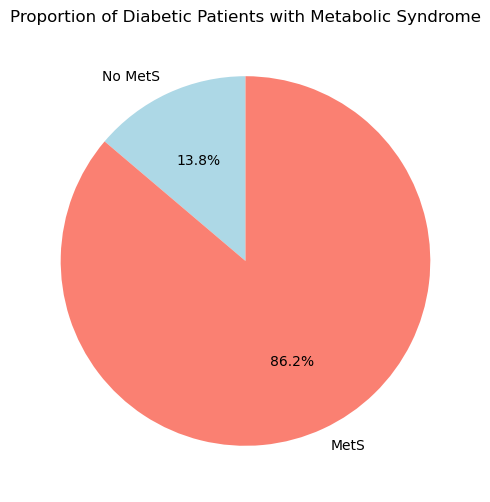

In [1105]:
import matplotlib.pyplot as plt


# Get value counts ensuring the correct order
diabetes_metS_counts = df[df['Diabetes_Status'] == 2]['MetS_3'].value_counts().sort_index()

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(diabetes_metS_counts, labels=["No MetS", "MetS"], autopct='%1.1f%%', startangle=90, colors=["lightblue","salmon"])
plt.title("Proportion of Diabetic Patients with Metabolic Syndrome")
plt.show()

#df['MetS_4'].value_counts()


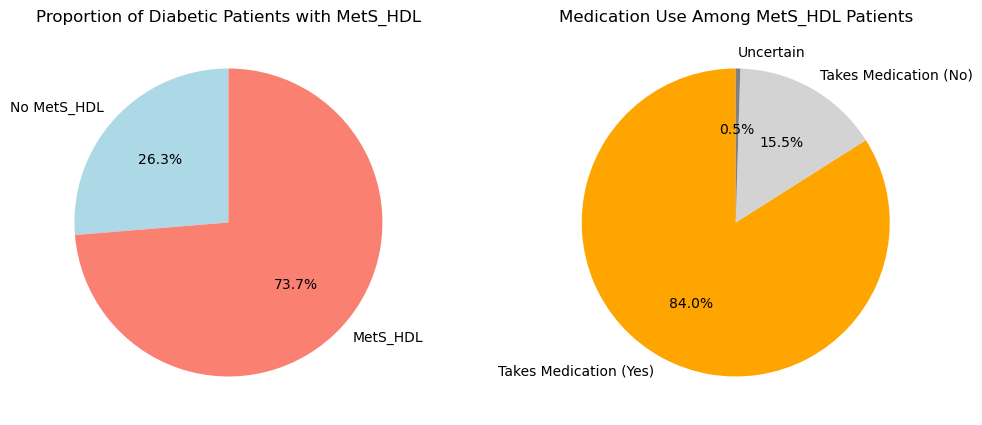

In [1106]:
import matplotlib.pyplot as plt

# Фильтруем только диабетиков
df_diabetes = df[df["Diabetes_Status"] == 2]

# Считаем, сколько диабетиков имеют MetS_HDL (низкий HDL или прием статинов)
hdl_counts = df_diabetes["MetS_HDL"].value_counts().sort_index()

# Среди тех, у кого MetS_HDL == 1, считаем, сколько принимают лекарства (BPQ090D)
medication_counts = df_diabetes[df_diabetes["MetS_HDL"] == 1]["BPQ090D"].value_counts().sort_index()

# 
medication_counts = medication_counts.reindex([1.0, 2.0, 33.0], fill_value=0)

# Переводим в понятные категории
labels = ["Takes Medication (Yes)", "Takes Medication (No)", "Uncertain"]
colors = ["orange", "lightgray", "gray"]

# Построение графиков
plt.figure(figsize=(12, 5))

# 📌 График 1: Доля диабетиков с MetS_HDL
plt.subplot(1, 2, 1)
plt.pie(hdl_counts, labels=["No MetS_HDL", "MetS_HDL"], autopct='%1.1f%%', startangle=90, colors=["lightblue", "salmon"])
plt.title("Proportion of Diabetic Patients with MetS_HDL")

# 📌 График 2: Доля принимающих лекарства среди MetS_HDL
plt.subplot(1, 2, 2)
plt.pie(medication_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Medication Use Among MetS_HDL Patients")

plt.show()

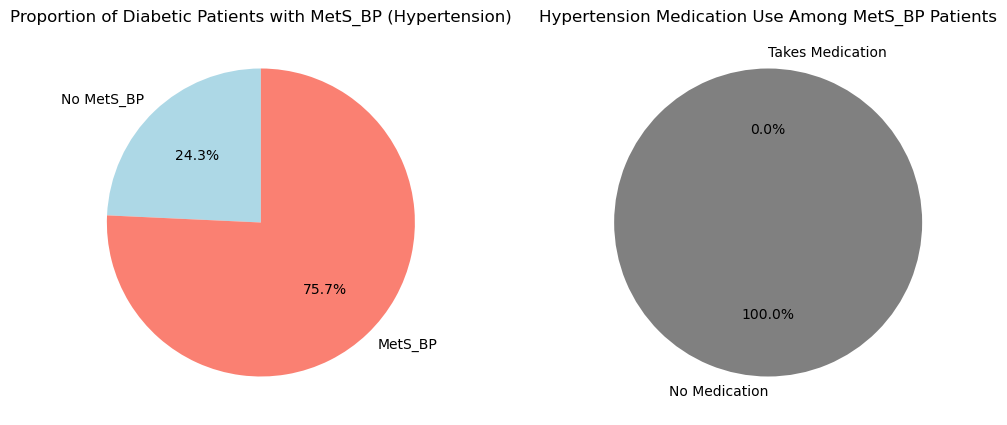

In [1107]:
import matplotlib.pyplot as plt

# Фильтруем только диабетиков
df_diabetes = df[df["Diabetes_Status"] == 2]

# 📌 1. Считаем, сколько диабетиков имеют MetS_BP (гипертонию)
bp_counts = df_diabetes["MetS_BP"].value_counts().sort_index()

# 📌 2. Считаем, сколько из них принимают лекарства от давления (BPQ040A и BPQ050A)
medication_counts_bp = df_diabetes[df_diabetes["MetS_BP"] == 0][["BPQ040A", "BPQ050A"]].apply(
    lambda x: 1 if (x == 1).any() else 0, axis=1
).value_counts().sort_index()

# 📌 Убедимся, что есть все три категории
medication_counts_bp = medication_counts_bp.reindex([0, 1], fill_value=0)

# 📊 Построение графиков
plt.figure(figsize=(12, 5))

# 📌 График 1: Доля диабетиков с MetS_BP (гипертонией)
plt.subplot(1, 2, 1)
plt.pie(bp_counts, labels=["No MetS_BP", "MetS_BP"], autopct='%1.1f%%', startangle=90, colors=["lightblue", "salmon"])
plt.title("Proportion of Diabetic Patients with MetS_BP (Hypertension)")

# 📌 График 2: Прием гипотензивных препаратов среди диабетиков с гипертонией
plt.subplot(1, 2, 2)
plt.pie(medication_counts_bp, labels=["No Medication", "Takes Medication"], autopct='%1.1f%%', startangle=90, colors=["gray", "orange"])
plt.title("Hypertension Medication Use Among MetS_BP Patients")

plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


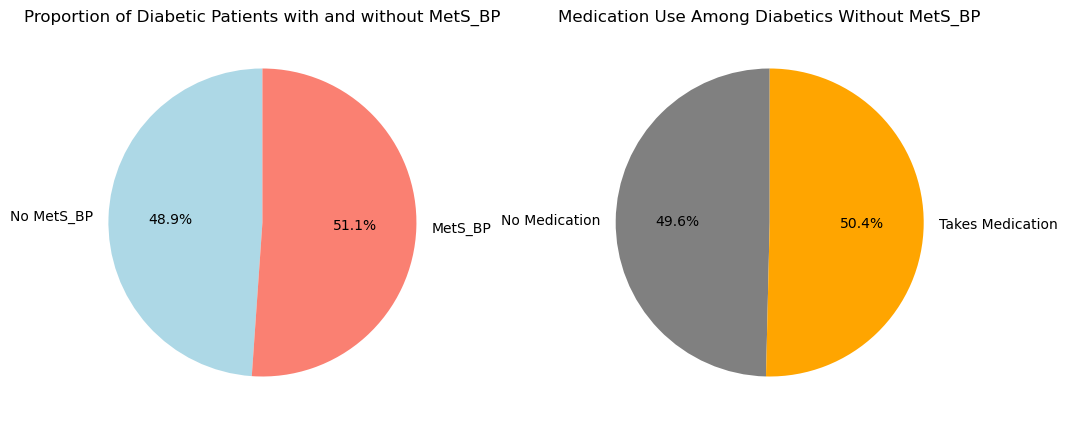

In [1083]:
import matplotlib.pyplot as plt

# 📌 1. Фильтруем только диабетиков
df_diabetes = df[df["Diabetes_Status"] == 2]

# 📌 2. Считаем, сколько диабетиков НЕ имеют MetS_BP (гипертонии)
bp_no_hypertension_counts = df_diabetes["MetS_BP"].value_counts().sort_index()

# 📌 3. Проверяем, сколько людей без MetS_BP принимают гипотензивные препараты
df_diabetes["Takes_Medication_BP"] = df_diabetes[["BPQ040A", "BPQ050A"]].apply(
    lambda x: 1 if (x == 1).any() else 0, axis=1
)

# 📌 4. Подсчет приема лекарств среди диабетиков, у которых MetS_BP = 0
medication_no_hypertension = df_diabetes[df_diabetes["MetS_BP"] == 0]["Takes_Medication_BP"].value_counts().sort_index()

# 📊 Построение графиков
plt.figure(figsize=(12, 5))

# 📌 График 1: Доля диабетиков без MetS_BP (гипертонии)
plt.subplot(1, 2, 1)
plt.pie(bp_no_hypertension_counts, labels=["No MetS_BP", "MetS_BP"], autopct='%1.1f%%', startangle=90, colors=["lightblue", "salmon"])
plt.title("Proportion of Diabetic Patients with and without MetS_BP")

# 📌 График 2: Прием гипотензивных препаратов среди диабетиков без гипертонии (MetS_BP = 0)
plt.subplot(1, 2, 2)
plt.pie(medication_no_hypertension, labels=["No Medication", "Takes Medication"], autopct='%1.1f%%', startangle=90, colors=["gray", "orange"])
plt.title("Medication Use Among Diabetics Without MetS_BP")

plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


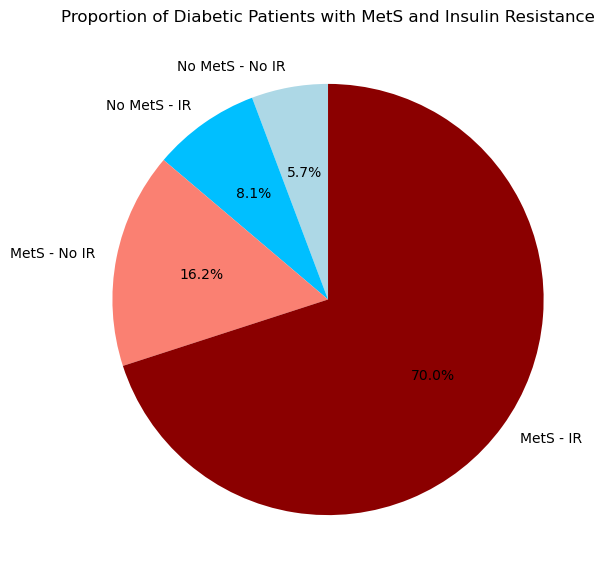

In [1108]:
import matplotlib.pyplot as plt

# 📌 Фильтруем диабетиков
df_diabetes = df[df["Diabetes_Status"] == 2]

# 📌 1. Считаем, сколько диабетиков имеют MetS (3 критерия)
mets_counts = df_diabetes["MetS_3"].value_counts().sort_index()

# 📌 2. Считаем, сколько из них имеют инсулинорезистентность
df_diabetes["Insulin_Resistant"] = (df_diabetes["HOMA_IR"] > 2.9).astype(int)

# 📌 3. Распределение инсулинорезистентности в группах MetS и No MetS
insulin_resistance_mets = df_diabetes[df_diabetes["MetS_3"] == 1]["Insulin_Resistant"].value_counts().reindex([0,1], fill_value=0)
insulin_resistance_no_mets = df_diabetes[df_diabetes["MetS_3"] == 0]["Insulin_Resistant"].value_counts().reindex([0,1], fill_value=0)

# 📌 4. Создаем список с размерами сегментов
sizes = [
    insulin_resistance_no_mets[0],  # No MetS, No Insulin Resistance
    insulin_resistance_no_mets[1],  # No MetS, Insulin Resistance
    insulin_resistance_mets[0],  # MetS, No Insulin Resistance
    insulin_resistance_mets[1]   # MetS, Insulin Resistance
]

# 📌 5. Подписи сегментов
labels = [
    "No MetS - No IR", "No MetS - IR",
    "MetS - No IR", "MetS - IR"
]

# 📌 6. Цвета сегментов
colors = ["lightblue", "deepskyblue", "salmon", "darkred"]

# 📊 Построение улучшенной диаграммы
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Proportion of Diabetic Patients with MetS and Insulin Resistance")

plt.show()

In [1087]:
df["BPQ050A"].value_counts()

1.0     9196
2.0     1422
33.0       2
Name: BPQ050A, dtype: int64

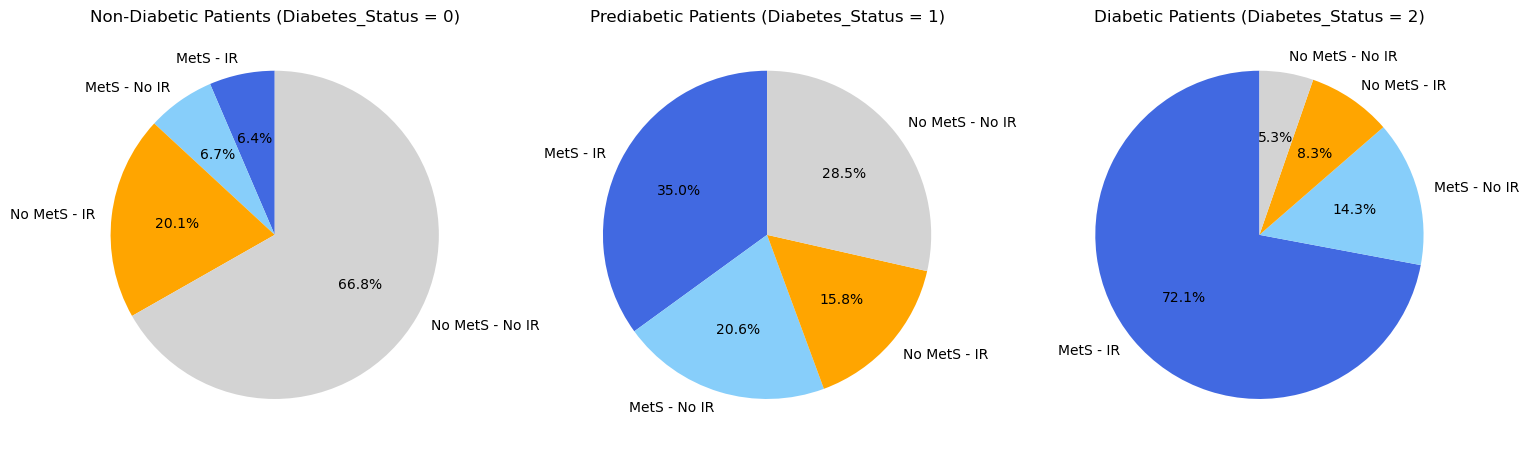

In [1113]:
import matplotlib.pyplot as plt

# Фильтруем данные по группам
df_diabetes = df[df["Diabetes_Status"] == 2]   # Группа с диабетом
df_prediabetes = df[df["Diabetes_Status"] == 1] # Группа с преддиабетом
df_no_diabetes = df[df["Diabetes_Status"] == 0] # Группа без диабета

# Функция для подсчета категорий
def get_metS_IR_counts(df):
    return df.groupby(["MetS_3", "Insulin_Resistance"]).size()

# 📌 Подсчет для диабета
counts_diabetes = get_metS_IR_counts(df_diabetes).reindex(
    [(1, 1), (1, 0), (0, 1), (0, 0)], fill_value=0
)

# 📌 Подсчет для преддиабета
counts_prediabetes = get_metS_IR_counts(df_prediabetes).reindex(
    [(1, 1), (1, 0), (0, 1), (0, 0)], fill_value=0
)

# 📌 Подсчет для группы без диабета
counts_no_diabetes = get_metS_IR_counts(df_no_diabetes).reindex(
    [(1, 1), (1, 0), (0, 1), (0, 0)], fill_value=0
)

# 📊 Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 📌 Диаграмма для диабетиков
axes[2].pie(
    counts_diabetes,
    labels=["MetS - IR", "MetS - No IR", "No MetS - IR", "No MetS - No IR"],
    autopct='%1.1f%%',
    startangle=90,
    colors = ["royalblue", "lightskyblue", "orange", "lightgray"]
)
axes[2].set_title("Diabetic Patients (Diabetes_Status = 2)")

# 📌 Диаграмма для преддиабетиков
axes[1].pie(
    counts_prediabetes,
    labels=["MetS - IR", "MetS - No IR", "No MetS - IR", "No MetS - No IR"],
    autopct='%1.1f%%',
    startangle=90,
    colors = ["royalblue", "lightskyblue", "orange", "lightgray"]
)
axes[1].set_title("Prediabetic Patients (Diabetes_Status = 1)")

# 📌 Диаграмма для группы без диабета
axes[0].pie(
    counts_no_diabetes,
    labels=["MetS - IR", "MetS - No IR", "No MetS - IR", "No MetS - No IR"],
    autopct='%1.1f%%',
    startangle=90,
    colors = ["royalblue", "lightskyblue", "orange", "lightgray"]
)
axes[0].set_title("Non-Diabetic Patients (Diabetes_Status = 0)")

plt.show()

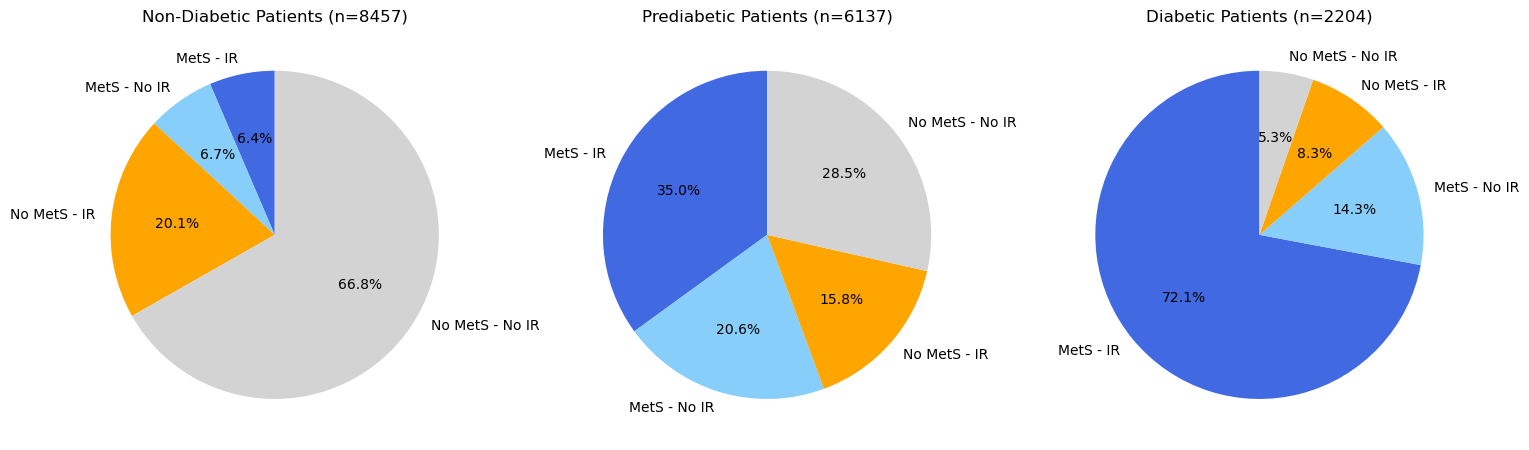

In [1116]:
import matplotlib.pyplot as plt

# Фильтруем данные по группам
df_diabetes = df[df["Diabetes_Status"] == 2]   # Группа с диабетом
df_prediabetes = df[df["Diabetes_Status"] == 1] # Группа с преддиабетом
df_no_diabetes = df[df["Diabetes_Status"] == 0] # Группа без диабета

# Функция для подсчета категорий
def get_metS_IR_counts(df):
    return df.groupby(["MetS_3", "Insulin_Resistance"]).size()

# 📌 Подсчет для диабета
counts_diabetes = get_metS_IR_counts(df_diabetes).reindex(
    [(1, 1), (1, 0), (0, 1), (0, 0)], fill_value=0
)
n_diabetes = counts_diabetes.sum()  # Количество наблюдений

# 📌 Подсчет для преддиабета
counts_prediabetes = get_metS_IR_counts(df_prediabetes).reindex(
    [(1, 1), (1, 0), (0, 1), (0, 0)], fill_value=0
)
n_prediabetes = counts_prediabetes.sum()  # Количество наблюдений

# 📌 Подсчет для группы без диабета
counts_no_diabetes = get_metS_IR_counts(df_no_diabetes).reindex(
    [(1, 1), (1, 0), (0, 1), (0, 0)], fill_value=0
)
n_no_diabetes = counts_no_diabetes.sum()  # Количество наблюдений

# 📊 Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 📌 Диаграмма для диабетиков
axes[2].pie(
    counts_diabetes,
    labels=["MetS - IR", "MetS - No IR", "No MetS - IR", "No MetS - No IR"],
    autopct='%1.1f%%',
    startangle=90,
    colors=["royalblue", "lightskyblue", "orange", "lightgray"]
)
axes[2].set_title(f"Diabetic Patients (n={n_diabetes})")

# 📌 Диаграмма для преддиабетиков
axes[1].pie(
    counts_prediabetes,
    labels=["MetS - IR", "MetS - No IR", "No MetS - IR", "No MetS - No IR"],
    autopct='%1.1f%%',
    startangle=90,
    colors=["royalblue", "lightskyblue", "orange", "lightgray"]
)
axes[1].set_title(f"Prediabetic Patients (n={n_prediabetes})")

# 📌 Диаграмма для группы без диабета
axes[0].pie(
    counts_no_diabetes,
    labels=["MetS - IR", "MetS - No IR", "No MetS - IR", "No MetS - No IR"],
    autopct='%1.1f%%',
    startangle=90,
    colors=["royalblue", "lightskyblue", "orange", "lightgray"]
)
axes[0].set_title(f"Non-Diabetic Patients (n={n_no_diabetes})")

plt.show()

In [1121]:
df_filtered = df.dropna(subset=["MetS_3", "Insulin_Resistance"])
print("Total patients considered in the chart:", df_filtered.shape[0])
df.groupby(["MetS_3", "Insulin_Resistance"]).size()

Total patients considered in the chart: 16827


MetS_3  Insulin_Resistance
0.0     0.0                   7533
        1.0                   2858
1.0     0.0                   2152
        1.0                   4284
dtype: int64

In [1122]:
df_no_diabetes_filtered = df_no_diabetes.dropna(subset=["MetS_3", "Insulin_Resistance"])
print("Total non-diabetic patients considered in the chart:", df_no_diabetes_filtered.shape[0])

Total non-diabetic patients considered in the chart: 8457


In [1120]:
print("Missing values in MetS_3:", df["MetS_3"].isna().sum())
print("Missing values in Insulin_Resistance:", df["Insulin_Resistance"].isna().sum())

Missing values in MetS_3: 18830
Missing values in Insulin_Resistance: 39141


In [1123]:
df["DIQ010"].value_counts()

2.0     48398
1.0      4479
3.0       874
33.0       28
Name: DIQ010, dtype: int64

In [1124]:
df["Diabetes_Status"].value_counts()

0.0    8706
1.0    6289
2.0    2272
Name: Diabetes_Status, dtype: int64

In [ ]:
Diabetes_Status
DIQ010
age
sucre
medicament

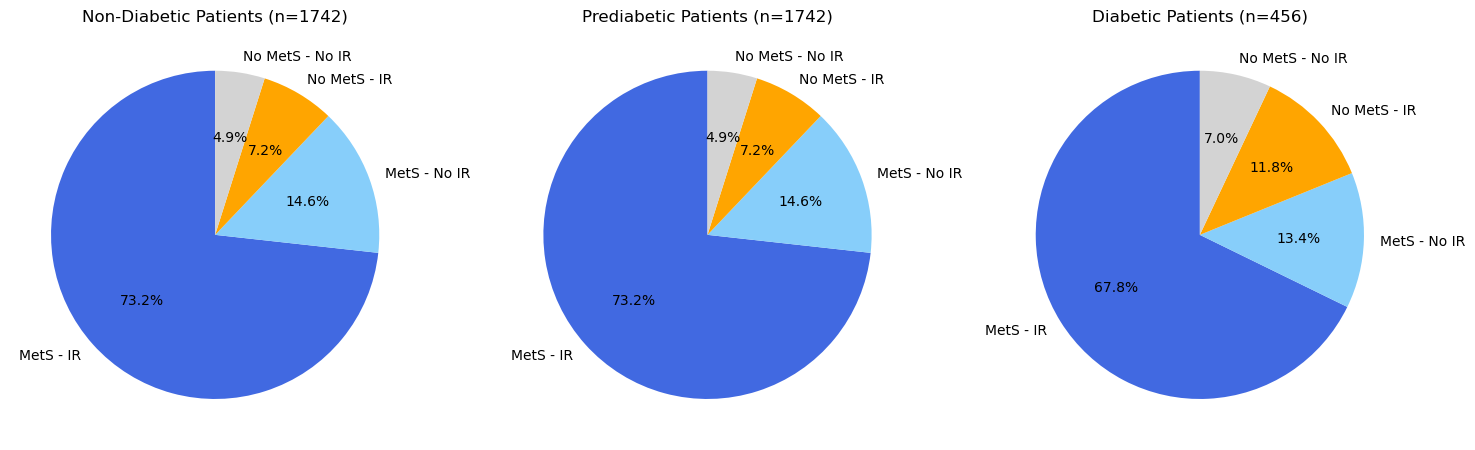

In [1128]:
import matplotlib.pyplot as plt

# Фильтруем данные по группам
df_diabetes = df[(df["Diabetes_Status"] == 2) & (df["PAQ635"] == 1)]
df_prediabetes = df[(df["Diabetes_Status"] == 2) & (df["PAQ635"] == 2)]
df_no_diabetes =  df[(df["Diabetes_Status"] == 2) & (df["PAQ635"] == 2)]

# Функция для подсчета категорий
def get_metS_IR_counts(df):
    return df.groupby(["MetS_3", "Insulin_Resistance"]).size()

# 📌 Подсчет для диабета
counts_diabetes = get_metS_IR_counts(df_diabetes).reindex(
    [(1, 1), (1, 0), (0, 1), (0, 0)], fill_value=0
)
n_diabetes = counts_diabetes.sum()  # Количество наблюдений

# 📌 Подсчет для преддиабета
counts_prediabetes = get_metS_IR_counts(df_prediabetes).reindex(
    [(1, 1), (1, 0), (0, 1), (0, 0)], fill_value=0
)
n_prediabetes = counts_prediabetes.sum()  # Количество наблюдений

# 📌 Подсчет для группы без диабета
counts_no_diabetes = get_metS_IR_counts(df_no_diabetes).reindex(
    [(1, 1), (1, 0), (0, 1), (0, 0)], fill_value=0
)
n_no_diabetes = counts_no_diabetes.sum()  # Количество наблюдений

# 📊 Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 📌 Диаграмма для диабетиков
axes[2].pie(
    counts_diabetes,
    labels=["MetS - IR", "MetS - No IR", "No MetS - IR", "No MetS - No IR"],
    autopct='%1.1f%%',
    startangle=90,
    colors=["royalblue", "lightskyblue", "orange", "lightgray"]
)
axes[2].set_title(f"Diabetic Patients (n={n_diabetes})")

# 📌 Диаграмма для преддиабетиков
axes[1].pie(
    counts_prediabetes,
    labels=["MetS - IR", "MetS - No IR", "No MetS - IR", "No MetS - No IR"],
    autopct='%1.1f%%',
    startangle=90,
    colors=["royalblue", "lightskyblue", "orange", "lightgray"]
)
axes[1].set_title(f"Prediabetic Patients (n={n_prediabetes})")

# 📌 Диаграмма для группы без диабета
axes[0].pie(
    counts_no_diabetes,
    labels=["MetS - IR", "MetS - No IR", "No MetS - IR", "No MetS - No IR"],
    autopct='%1.1f%%',
    startangle=90,
    colors=["royalblue", "lightskyblue", "orange", "lightgray"]
)
axes[0].set_title(f"Non-Diabetic Patients (n={n_no_diabetes})")

plt.show()

In [1125]:
df["PAQ635"].value_counts()

2.0     27385
1.0     10672
33.0        4
Name: PAQ635, dtype: int64

In [1134]:
#df[(df["Diabetes_Status"] == 2) & (df["PAQ635"] == 2)].value

aaa = df.dropna(subset=["PAQ635", "MetS_3",])

print("Total non-diabetic patients considered in the chart:", aaa.shape[0])

Total non-diabetic patients considered in the chart: 16228


# **Dataset Variables Description**

## **1. Identifier**
| # | Feature Name | Type | Question | Subcategories |
|---|-------------|------|----------|--------------|
| 1 | **SEQN** | Identifier | What is the respondent's unique identifier? | (not required) |

## **2. Body Measures (P_BMX)**
| # | Feature Name | Type | Question | Subcategories |
|---|-------------|------|----------|--------------|
| 2 | **BMXWT** | Numeric | What is the patient's weight (kg)? | (not required) |
| 3 | **BMXHT** | Numeric | What is the patient's height (cm)? | (not required) |
| 4 | **BMXBMI** | Numeric | What is the patient's Body Mass Index (kg/m²)? | (not required) |
| 5 | **BMXWAIST** | Numeric | What is the patient's waist circumference (cm)? | (not required) |
| 6 | **WHtR** | Numeric | What is the patient's waist-to-height ratio (BMXWAIST / BMXHT)? | (not required) |

## **3. Blood Pressure (P_BPXO)**
| # | Feature Name | Type | Question | Subcategories |
|---|-------------|------|----------|--------------|
| 7 | **AvgSystolicBP** | Numeric | What is the patient's average systolic blood pressure (mmHg)? | (not required) |
| 8 | **AvgDiastolicBP** | Numeric | What is the patient's average diastolic blood pressure (mmHg)? | (not required) |
| 9 | **PulsePressure** | Numeric | What is the patient's pulse pressure (mmHg)? | (not required) |
| 10 | **AvgPulseRate** | Numeric | What is the patient's average pulse rate (beats per minute)? | (not required) |

## **4. Demographics Data (P_DEMO)**
| # | Feature Name | Type | Question | Subcategories |
|---|-------------|------|----------|--------------|
| 11 | **SDDSRVYR** | Categorical | What is the survey cycle (year)? | (varies) |
| 12 | **RIAGENDR** | Categorical | What is the patient's gender? | Male \| Female |
| 13 | **RIDAGEYR** | Numeric | What is the patient's age (years)? | (not required) |
| 14 | **RIDRETH3** | Categorical | What is the patient's race/ethnicity? | (varies) |
| 15 | **DMDBORN4** | Categorical | What is the patient's country of birth? | (varies) |
| 16 | **DMDEDUC2** | Categorical | What is the patient's education level? | (varies) |
| 17 | **RIDEXPRG** | Categorical | Is the patient pregnant? | Yes \| No |
| 18 | **INDFMPIR** | Numeric | What is the patient's income-to-poverty ratio? | (not required) |
| 19 | **DMDMARTZ** | Categorical | What is the patient's marital status? | (varies) |

## **5. Lab Tests (P_LAB)**
| # | Feature Name | Type | Question | Subcategories |
|---|-------------|------|----------|--------------|
| 20 | **LBDGLUSI** | Numeric | What is the patient's fasting glucose level (mmol/L)? | (not required) |
| 21 | **LBXIN** | Numeric | What is the patient's insulin level (µU/mL)? | (not required) |
| 22 | **LBXGH** | Numeric | What is the patient's glycated hemoglobin (HbA1c, %)? | (not required) |
| 23 | **LBDTCSI** | Numeric | What is the patient's total cholesterol (mmol/L)? | (not required) |

## **6. Alcohol Use (P_ALQ)**
| # | Feature Name | Type | Question | Subcategories |
|---|-------------|------|----------|--------------|
| 24 | **ALQ111** | Categorical | Has the patient ever consumed alcohol? | Yes \| No |
| 25 | **ALQ121** | Categorical | How frequently has the patient consumed alcohol in the past year? | Never \| Occasionally \| Regularly |
| 26 | **ALQ130** | Numeric | What is the average number of drinks per day? | (not required) |

## **7. Diabetes (P_DIQ)**
| # | Feature Name | Type | Question | Subcategories |
|---|-------------|------|----------|--------------|
| 27 | **DIQ160** | Categorical | Has the patient been told they have prediabetes? | Yes \| No |
| 28 | **DIQ010** | Categorical | Has the doctor diagnosed the patient with diabetes? | Yes \| No |
| 29 | **DID040** | Numeric | At what age was the patient diagnosed with diabetes? | (not required) |

## **8. Diet Behavior & Nutrition (P_DBQ)**
| # | Feature Name | Type | Question | Subcategories |
|---|-------------|------|----------|--------------|
| 30 | **DBD900** | Numeric | How many fast food meals has the patient had in the past 30 days? | (not required) |
| 31 | **DBQ700** | Categorical | How healthy is the patient's diet? | Poor \| Average \| Healthy |

## **9. Physical Activity (P_PAQ)**
| # | Feature Name | Type | Question | Subcategories |
|---|-------------|------|----------|--------------|
| 32 | **PAQ605** | Categorical | Does the patient have an active job? | Yes \| No |
| 33 | **PAQ665** | Categorical | How frequently does the patient engage in moderate exercise? | Low \| Moderate \| High |
| 34 | **PAD680** | Numeric | How many minutes of sedentary activity does the patient have per day? | (not required) |

## **10. Sleep Disorders (P_SLQ)**
| # | Feature Name | Type | Question | Subcategories |
|---|-------------|------|----------|--------------|
| 35 | **SLD012** | Numeric | What is the patient's average sleep duration on weekdays (hours)? | (not required) |

## **11. Smoking - Cigarette Use (P_SMQ)**
| # | Feature Name | Type | Question | Subcategories |
|---|-------------|------|----------|--------------|
| 36 | **SMQ020** | Categorical | Has the patient ever smoked 100 or more cigarettes? | Yes \| No |
| 37 | **SMD650** | Numeric | What is the average number of cigarettes per day in the past 30 days? | (not required) |

#### **12. Target Variables**
| # | Feature Name | Type | Question | Subcategories |
|---|-------------|------|----------|--------------|
| 38 | **Diabetes_Status** | Categorical | Has the patient been diagnosed with diabetes? | Yes \| No |
| 39 | **Insulin_Resistance** | Categorical | Has the patient been diagnosed with insulin resistance? | Yes \| No |

# **Dataset Variables Description**

## **Table of Contents**
1. [Identifier](#1-identifier)
2. [Body Measures (P_BMX)](#2-body-measures-p_bmx)
3. [Blood Pressure (P_BPXO)](#3-blood-pressure-p_bpxo)
4. [Demographics Data (P_DEMO)](#4-demographics-data-p_demo)
5. [Lab Tests (P_LAB)](#5-lab-tests-p_lab)
6. [Alcohol Use (P_ALQ)](#6-alcohol-use-p_alq)
7. [Diabetes (P_DIQ)](#7-diabetes-p_diq)
8. [Diet Behavior & Nutrition (P_DBQ)](#8-diet-behavior--nutrition-p_dbq)
9. [Physical Activity (P_PAQ)](#9-physical-activity-p_paq)
10. [Sleep Disorders (P_SLQ)](#10-sleep-disorders-p_slq)
11. [Smoking - Cigarette Use (P_SMQ)](#11-smoking---cigarette-use-p_smq)
12. [Target Variables](#12-target-variables)

---

## **1. Identifier**
| #  | Feature Name | Type       | Question                                         | Subcategories           |
|----|-------------|------------|-------------------------------------------------|--------------------------|
| 1  | **SEQN**    | Identifier | What is the respondent's unique identifier?     | (not required)          |

## **2. Body Measures (P_BMX)**
| #  | Feature Name  | Type     | Question                                        | Subcategories |
|----|-------------|---------|------------------------------------------------|--------------|
| 2  | **BMXWT**   | Numeric | What is the patient's weight (kg)?             | (not required) |
| 3  | **BMXHT**   | Numeric | What is the patient's height (cm)?             | (not required) |
| 4  | **BMXBMI**  | Numeric | What is the patient's Body Mass Index (kg/m²)? | (not required) |
| 5  | **BMXWAIST**| Numeric | What is the patient's waist circumference (cm)? | (not required) |
| 6  | **WHtR**    | Numeric | What is the patient's waist-to-height ratio?    | (not required) |

---

### 🔥 **Как работают ссылки?**  
- Markdown автоматически создаёт **якоря** для заголовков.  
- Пробелы заменяются на `-`, а текст приводится к **нижнему регистру**.  
- Например, `## 1. Identifier` превращается в `#1-identifier`.  

🚀 Теперь у тебя **кликабельное оглавление**, и ты можешь легко перемещаться по документу в Markdown-редакторах!  

Хочешь, чтобы я сразу добавил это в твой файл? 😊

# **Dataset Variables Description**

## **Table of Contents**
1. [Identifier](#identifier)
2. [Body Measures (P_BMX)](#body-measures-p_bmx)
3. [Blood Pressure (P_BPXO)](#blood-pressure-p_bpxo)
4. [Demographics Data (P_DEMO)](#demographics-data-p_demo)
5. [Lab Tests (P_LAB)](#lab-tests-p_lab)
6. [Alcohol Use (P_ALQ)](#alcohol-use-p_alq)
7. [Diabetes (P_DIQ)](#diabetes-p_diq)
8. [Diet Behavior & Nutrition (P_DBQ)](#diet-behavior--nutrition-p_dbq)
9. [Physical Activity (P_PAQ)](#physical-activity-p_paq)
10. [Sleep Disorders (P_SLQ)](#sleep-disorders-p_slq)
11. [Smoking - Cigarette Use (P_SMQ)](#smoking---cigarette-use-p_smq)
12. [Target Variables](#target-variables)



## Blood Pressure (P_BPXO)
| #  | Feature Name      | Type     | Question                                      | Subcategories |
|----|------------------|---------|----------------------------------------------|--------------|
| 7  | **AvgSystolicBP**  | Numeric | What is the patient's average systolic blood pressure (mmHg)?         | (not required) |
| 8  | **AvgDiastolicBP** | Numeric | What is the patient's average diastolic blood pressure (mmHg)? | (not required) |
| 9  | **PulsePressure**  | Numeric | What is the patient's pulse pressure (mmHg)? | (not required) |
| 10 | **AvgPulseRate**   | Numeric | What is the patient's average pulse rate (beats per minute)? | (not required) |

## Demographics Data (P_DEMO)
| #  | Feature Name  | Type       | Question                                      | Subcategories |
|----|-------------|------------|----------------------------------------------------|--------------|
| 11 | **SDDSRVYR** | Categorical |What is the survey cycle (year)? <br> What is the survey cycle (year)?| (varies) |
| 12 | **RIAGENDR** | Categorical | What is the patient's gender?                 | Male \| Female |
| 13 | **RIDAGEYR** | Numeric     | What is the patient's age (years)?            | (not required) |
| 14 | **RIDRETH3** | Categorical | What is the patient's race/ethnicity?         | (varies) |
| 15 | **DMDBORN4** | Categorical | What is the patient's country of birth?       | (varies) |
| 16 | **DMDEDUC2** | Categorical | What is the patient's education level?        | (varies) |
| 17 | **RIDEXPRG** | Categorical | Is the patient pregnant?                      | Yes \| No |
| 18 | **INDFMPIR** | Numeric     | What is the patient's income-to-poverty ratio?| (not required) |
| 19 | **DMDMARTZ** | Categorical | What is the patient's marital status?         | (varies) |

## Lab Tests (P_LAB)
| #  | Feature Name | Type     | Question                                      | Subcategories |
|----|-------------|---------|----------------------------------------------|--------------|
| 20 | **LBDGLUSI** | Numeric | What is the patient's fasting glucose level (mmol/L)? | (not required) |
| 21 | **LBXIN**    | Numeric | What is the patient's insulin level (µU/mL)? | (not required) |
| 22 | **LBXGH**    | Numeric | What is the patient's glycated hemoglobin (HbA1c, %)? | (not required) |
| 23 | **LBDTCSI**  | Numeric | What is the patient's total cholesterol (mmol/L)? | (not required) |
| 24 | **LBDHDDSI** | Numeric | What is the patient's HDL cholesterol (mmol/L)? | (not required) |
| 25 | **LBXTR**    | Numeric | What is the patient's triglyceride level (mg/dL)? | (not required) |
| 26 | **LBDLDL**   | Numeric | What is the patient's LDL cholesterol (mmol/L)? | (not required) |

## Alcohol Use (P_ALQ)
| #  | Feature Name | Type     | Question                                      | Subcategories |
|----|-------------|---------|----------------------------------------------|--------------|
| 27 | **ALQ111**  | Categorical | Has the patient ever consumed alcohol? | Yes \| No |
| 28 | **ALQ121**  | Categorical | How frequently has the patient consumed alcohol in the past year? | Never \| Occasionally \| Regularly |
| 29 | **ALQ130**  | Numeric     | What is the average number of drinks per day? | (not required) |

## Diabetes (P_DIQ)
| #  | Feature Name | Type     | Question                                      | Subcategories |
|----|-------------|---------|----------------------------------------------|--------------|
| 30 | **DIQ160**  | Categorical | Has the patient been told they have prediabetes? | Yes \| No |
| 31 | **DIQ010**  | Categorical | Has the doctor diagnosed the patient with diabetes? | Yes \| No |
| 32 | **DID040**  | Numeric     | At what age was the patient diagnosed with diabetes? | (not required) |

## Diet Behavior & Nutrition (P_DBQ)
| #  | Feature Name | Type     | Question                                      | Subcategories |
|----|-------------|---------|----------------------------------------------|--------------|
| 33 | **DBD900**  | Numeric | How many fast food meals has the patient had in the past 30 days? | (not required) |
| 34 | **DBQ700**  | Categorical | How healthy is the patient's diet? | Poor \| Average \| Healthy |

## Physical Activity (P_PAQ)
| #  | Feature Name | Type     | Question                                      | Subcategories |
|----|-------------|---------|----------------------------------------------|--------------|
| 35 | **PAQ605**  | Categorical | Does the patient have an active job? | Yes \| No |
| 36 | **PAQ665**  | Categorical | How frequently does the patient engage in moderate exercise? | Low \| Moderate \| High |
| 37 | **PAD680**  | Numeric     | How many minutes of sedentary activity does the patient have per day? | (not required) |

## Sleep Disorders (P_SLQ)
| #  | Feature Name | Type     | Question                                      | Subcategories |
|----|-------------|---------|----------------------------------------------|--------------|
| 38 | **SLD012**  | Numeric | What is the patient's average sleep duration on weekdays (hours)? | (not required) |

## Smoking - Cigarette Use (P_SMQ)
| #  | Feature Name | Type     | Question                                      | Subcategories |
|----|-------------|---------|----------------------------------------------|--------------|
| 39 | **SMQ020**  | Categorical | Has the patient ever smoked 100 or more cigarettes? | Yes \| No |
| 40 | **SMD650**  | Numeric     | What is the average number of cigarettes per day in the past 30 days? | (not required) |

## Target Variables
| #  | Feature Name | Type     | Question                                      | Subcategories |
|----|-------------|---------|----------------------------------------------|--------------|
| 41 | **Diabetes_Status** | Categorical | Has the patient been diagnosed with diabetes? | Yes \| No |
| 42 | **Insulin_Resistance** | Categorical | Has the patient been diagnosed with insulin resistance? | Yes \| No |